# Download the data

In [6]:
import tensorflow as tf

import numpy as np

from sklearn.preprocessing import LabelBinarizer # one hot
from sklearn.model_selection import train_test_split
import os
from glob import glob

# for model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPool2D, GlobalAvgPool2D, Dense, GlobalMaxPooling2D, Activation, multiply, Concatenate, Reshape, Lambda
from tensorflow.keras import Model
import tensorflow.keras.backend as K
 
import matplotlib.pyplot as plt

In [ ]:
# download the dataset
! pip install opendatasets --upgrade
import opendatasets as od

dic = {"username":"sanjartechie","key":"82c494b2e40d1e481393dcf1d0e797d8"} # kaggle.jason

data_dir = '/content'
data_url = 'https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/download'
if not os.path.exists(data_dir + '/ham1000'):
  od.download(data_url, data_dir=data_dir)
else:
  print('\n -> dataset exists')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sanjartechie
Your Kaggle Key: ··········


100%|██████████| 5.20G/5.20G [01:46<00:00, 52.5MB/s]

# EDA

Image fromat: JPEG
Image mode: RGB
Original image size: (450, 600, 3)



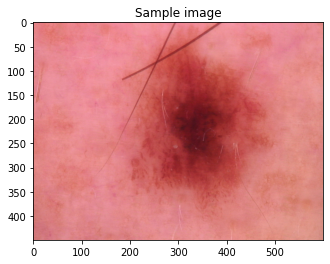

In [ ]:
# print the metadata of sample image from the dataset
image_org = tf.keras.utils.load_img("/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg")
print(f'Image fromat: {image_org.format}')
print(f'Image mode: {image_org.mode}')
# conovert PILL image instace into numpy array
image_org = tf.keras.preprocessing.image.img_to_array(image_org)
print(f'Original image size: {image_org.shape}\n')
plt.title('Sample image')
plt.imshow(image_org/255.0)

In [ ]:
data_dir = '/content/skin-cancer-mnist-ham10000'
image_part1_dir = os.path.join(data_dir,  'HAM10000_images_part_1')
image_part2_dir = os.path.join(data_dir, 'HAM10000_images_part_2')

print(f'Num of images Part1: {len(os.listdir(image_part1_dir))}')
print(f'Num of images Part2: {len(os.listdir(image_part2_dir))}')

Num of images Part1: 5000
Num of images Part2: 5015


In [ ]:
# take a look at the metadata
import pandas as pd
df = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df.head(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
# store the image id and dx-labels in a dictionary
image_id_dict = dict()
image_ids = list(df['image_id'])
labels = list(df['dx'])
for i in range(len(image_ids)):
  image_id_dict[image_ids[i]] = labels[i]

In [ ]:
# frequency of modalities
def countFreq(arr, n):  
  mp = {}
  freq_dict = dict()
    
  for i in range(n):
      if arr[i] not in mp:
          mp[arr[i]] = 0
      mp[arr[i]] += 1
        
  for i in range(n):
      if (mp[arr[i]] != -1):
          freq_dict[arr[i]] = mp[arr[i]]
      mp[arr[i]] = -1
  return freq_dict
    
l = len(labels)
labels_freq = countFreq(labels, l)    

In [ ]:
# define hyperparameters
CLASSES = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

IMG_SIZE = 64
EPOCHS = 4
BATCH_SIZE = 32
BUFFER_SIZE = 256

SEED = 999 # for reproducibility

In [ ]:
def load_images_and_labels(image_paths, image_id_dict, target_size):
    
    """ Load and preprocess the dataset into the right np format 
    # Arguments
        image_path (array): An array that stores all the image paths
        target_size (Tuple): Size of image to be converted
        id_and_labels(dictionary): Dictionary of each image id and corresponding label

    # Returns
        x (Tuple): Tuple containing images and labels in numpy array
    """

    # an array to append each preprocessed image
    images = []

    #load the images
    for image_path in image_paths:
        # load the image. Returns PILL image instabce
        image = tf.keras.utils.load_img(image_path, target_size=target_size)
        # conovert PILL image instace into numpy array
        image = tf.keras.preprocessing.image.img_to_array(image)
        # image = np.array([image]) #into batch
        images.append(image) 

    # encode the labels based on its index in CLASSSES list
    labels = [CLASSES.index(image_id_dict[(name.split('/')[-1]).split('.')[-2]]) for name in image_paths] 

    # convert list object into numpy array and return
    return np.array(images), np.array(labels)

# test
sample_img_path = glob(image_part1_dir + '/*.jpg')[:10] # sample image from training 
sample_img, sample_label = load_images_and_labels(sample_img_path, image_id_dict=image_id_dict, target_size=(IMG_SIZE, IMG_SIZE))
print(f'10 sample image array shape: {sample_img.shape}')
print(f'10 sample label: {sample_label}') # encoded - not one hot 

10 sample image array shape: (10, 64, 64, 3)
10 sample label: [3 0 1 1 1 1 1 1 1 6]


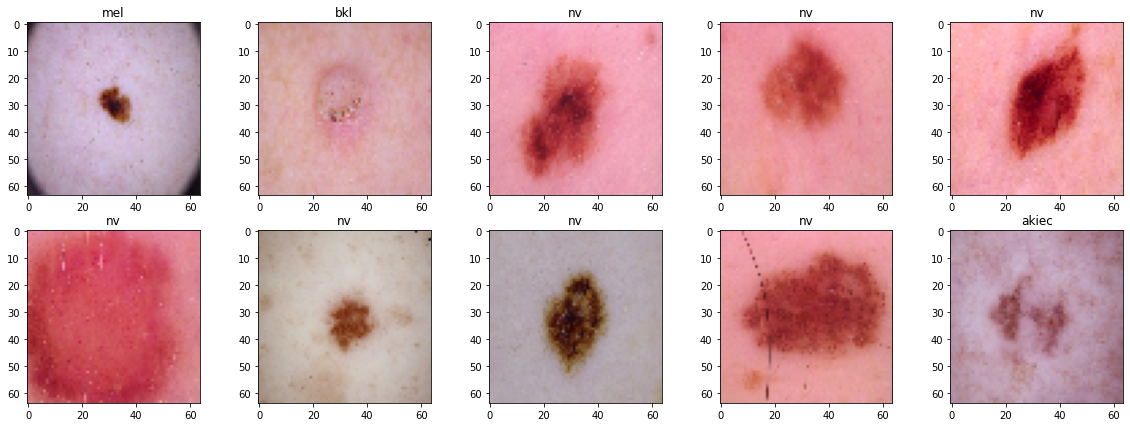

In [ ]:
from IPython.core.pylabtools import figsize
# plot the 10 sample images from
plt.figure(figsize = (20, 7))
for i in range(len(sample_img)):
  plt.subplot(2, 5, i+1)
  plt.title(CLASSES[sample_label[i]])
  plt.imshow(sample_img[i]/255.0)

In [ ]:
# Define 'list' of all trainimage filenames
part1_filenames = glob(image_part1_dir + '/*.jpg')
part2_filenames = glob(image_part2_dir + '/*.jpg')
filenames = part1_filenames + part2_filenames
# load all the images and corresponding labels
X, y = load_images_and_labels(filenames, image_id_dict=image_id_dict, target_size=(IMG_SIZE, IMG_SIZE))

In [ ]:
# split the dataset into training and test beforehand
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=SEED)

In [ ]:
len(filenames)

10015

Distribution of classes:
{'bkl': 879, 'nv': 5364, 'df': 92, 'mel': 890, 'vasc': 114, 'bcc': 411, 'akiec': 262} 



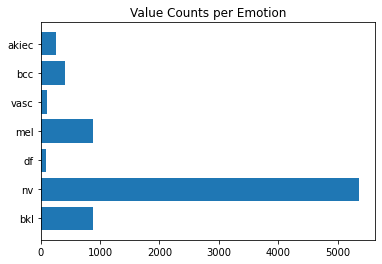

In [ ]:
# class distribution

def plot_distribution(y_):
    plt.title('Value Counts per Emotion')
    x = CLASSES
    y = [list(y_).count(i) for i in range(len(x))] 
    # print(y)
    print("Distribution of classes:")
    # unique elements of an array, these elements frequency - return+counts=True
    unique, counts = np.unique(y_, return_counts=True)
    print(dict(zip(x, counts)), '\n')
    
    plt.barh(x, y)

plot_distribution(y_train)

*Observation: Imbalance exists*
Handling mechanism
> - random oversampling and undersampling pipeline for all classes except 'nv'
> - train with class weights to handle imbalance between 'nv' and other classes



In [ ]:
# Handle Imbalance
import random
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline

#define dictionary of desired frequencies 

# dict for oversampling 
d_over = {0: 1595, 2: 1197, 3: 1523, 4: 1011, 5: 1584, 6: 1046}
# dict for undersampling
d_under = {1: 3875}

# make a pipeline
pipe = make_pipeline(
    SMOTE(sampling_strategy=d_over),
    NearMiss(sampling_strategy=d_under))

# apply the over-under-sampling method to training images
def apply_pipeline(X, y):
    examples, h, w, c = [X.shape[index] for index in range(4)]
    X_reshaped = X.reshape(examples, h*w*c)
    X_smt, y_smt = pipe.fit_resample(X_reshaped, y)
    return X_smt, y_smt

In [ ]:
X_pipe, y_pipe = apply_pipeline(X_train, y_train)

Distribution of classes:
{'bkl': 1595, 'nv': 3875, 'df': 1197, 'mel': 1523, 'vasc': 1011, 'bcc': 1584, 'akiec': 1046} 



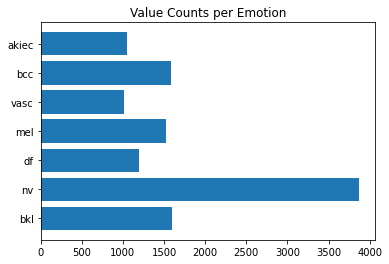

In [ ]:
# Plot the distribution after handling imbalance
plot_distribution(y_pipe)

*Observation: Imbalance among 4 classes has been handled. The rest will be handled with class weights* 

In [ ]:
# Reshape the training images into 4D again
X_train_new = X_pipe.reshape((X_pipe.shape[0], IMG_SIZE, IMG_SIZE, 3))
y_train_new = y_pipe

print(f'X_train shape: {X_train.shape} \ny_train shape: {y_train.shape}')

X_train shape: (8012, 64, 64, 3) 
y_train shape: (8012,)


In [ ]:
# find the class weights
class_weights = dict()

unique, counts = np.unique(y_train_new, return_counts=True)
total = len(y_train_new)
for i in range(len(unique)):
  class_weights[unique[i]] = round(total / counts[i], 1)
class_weights

{0: 7.4, 1: 3.1, 2: 9.9, 3: 7.8, 4: 11.7, 5: 7.5, 6: 11.3}

Model

In [ ]:
# model with cbam and without cbam - benchmark
from models.resnet50 import resnet50
model_cbam = resnet50(IMG_SIZE, cbam=True)
model_benchmark = resnet50(IMG_SIZE, cbam=False)

Training Pipeline

In [ ]:
def augment_using_ops(images, labels):
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)
	return (images, labels)

In [ ]:
# Normalize the X input 
from sklearn.model_selection import train_test_split
X_train_new /= 255.0
(X_t, X_val, y_t, y_val) = train_test_split(X_train_new, y_train_new, test_size=0.2, stratify=y_train_new, shuffle = True, random_state=SEED)

In [ ]:
# # # one hot encode the labels
# from sklearn.preprocessing import LabelBinarizer
# label_bin = LabelBinarizer()
# y_train = label_bin.fit_transform(y_train)
# y_val = label_bin.fit_transform(y_val)

# # for optimal performance, create tf.data.dataset  for model input 
train_ds = (tf.data.Dataset.from_tensor_slices((X_t, y_t)))
val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val)))

# create batches, apply prefetch (spawns background threads)
train_dataset = train_ds.shuffle(buffer_size=BUFFER_SIZE).cache().batch(BATCH_SIZE).map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=BUFFER_SIZE)
val_dataset = val_ds.shuffle(buffer_size=BUFFER_SIZE).cache().batch(BATCH_SIZE).map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=BUFFER_SIZE)

In [ ]:
model_cbam.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_benchmark.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# this code is for training

history_cbam = model_cbam.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=EPOCHS, class_weight=class_weights
          )

# model_cbam.save('cbam.hdf5')



Epoch 1/4
296/296 [==============================] - 28s 93ms/step - loss: 1.6596 - accuracy: 0.8849 - val_loss: 1.0671 - val_accuracy: 0.7245
Epoch 2/4
296/296 [==============================] - 28s 93ms/step - loss: 1.6067 - accuracy: 0.8899 - val_loss: 0.9113 - val_accuracy: 0.7106
Epoch 3/4
296/296 [==============================] - 28s 93ms/step - loss: 1.7111 - accuracy: 0.8899 - val_loss: 1.0184 - val_accuracy: 0.7300
Epoch 4/4
296/296 [==============================] - 28s 93ms/step - loss: 1.4793 - accuracy: 0.8979 - val_loss: 0.9397 - val_accuracy: 0.7216


In [ ]:
# benchmark traininig

history_benchmark = model_benchmark.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=EPOCHS, class_weight=class_weights
          )

# model_benchmark.save('cbam_benchmark.hdf5')

Epoch 1/40
296/296 [==============================] - 23s 55ms/step - loss: 13.1140 - accuracy: 0.4275 - val_loss: 2.4800 - val_accuracy: 0.1926
Epoch 2/40
296/296 [==============================] - 14s 47ms/step - loss: 8.7011 - accuracy: 0.5470 - val_loss: 1.4566 - val_accuracy: 0.4280
Epoch 3/40
296/296 [==============================] - 14s 47ms/step - loss: 8.6891 - accuracy: 0.5623 - val_loss: 2.0604 - val_accuracy: 0.4313
Epoch 4/40
296/296 [==============================] - 14s 47ms/step - loss: 7.0698 - accuracy: 0.6201 - val_loss: 2.0294 - val_accuracy: 0.3262
Epoch 5/40
296/296 [==============================] - 15s 49ms/step - loss: 6.0669 - accuracy: 0.6693 - val_loss: 1.1619 - val_accuracy: 0.6451
Epoch 6/40
296/296 [==============================] - 14s 47ms/step - loss: 6.3259 - accuracy: 0.6494 - val_loss: 1.4597 - val_accuracy: 0.4461
Epoch 7/40
296/296 [==============================] - 14s 47ms/step - loss: 5.3092 - accuracy: 0.6928 - val_loss: 1.4181 - val_accuracy

Training courve

In [ ]:
#@title
# plot the loss and accuracy curve with tf docs
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs 
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-jxyiyqu6
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-jxyiyqu6
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=162411 sha256=0ef9f008f5065cf68c9534868070a0b61a78d795287e92b05fc326247dba671a
  Stored in directory: /tmp/pip-ephem-wheel-cache-zmp9xpsh/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
#@title
def plot_model_history(model_history, metric, ylim=None):
  plt.style.use('seaborn-darkgrid')
  plotter = tfdocs.plots.HistoryPlotter()
  plotter.plot({'Model': model_history}, metric=metric)

  plt.title(f'{metric.upper()}')
  if ylim is None:
    plt.ylim([0, 1])
  else:
    plt.ylim(ylim)

  plt.savefig(f'b_{metric}.png')
  plt.close()

plot_model_history(history_benchmark, 'accuracy')

Testing& Evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the models 
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model

model_cbam = load_model('/content/cbam.hdf5')
model_benchmark = load_model('/content/cbam_benchmark.hdf5')

In [ ]:
# # prepare the testing dataset
# y_test = label_bin.fit_transform(y_test) # one-hot
X_test /= 255.0 # normalize
test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test))) # tf.data.Dataset

# consume into batches for model input
test_dataset = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=BUFFER_SIZE)

In [ ]:
# evaluate the model
benchmark_results = model_benchmark.evaluate(test_dataset)
cbam_results = model_cbam.evaluate(test_dataset)


63/63 [==============================] - 2s 37ms/step - loss: 1.6012 - accuracy: 0.5821


GradCam Visualizations

In [ ]:
# last cov layer for gradcam
last_conv_layer_cbam = 'concatenate_17'
last_conv_layer_benchmark = 're_lu_96'

In [ ]:
# gradcam algorithm
import cv2
def VizGradCAM(model, image, layer_name , interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

#     last_conv_layer = next(
#         x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
#     )
    last_conv_layer = model.get_layer(layer_name)
    target_layer = model.get_layer(last_conv_layer.name)
    
    
    original_img = image
    img = np.expand_dims(original_img, axis=0)
    # img = original_img
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)) , cvt_heatmap,prediction

In [ ]:
# the results of model_cbam
def plot_grad_cam(model_choice, img_index: int):
  
  sample_img_path = filenames[img_index]

  img = tf.keras.utils.load_img(sample_img_path, target_size=(IMG_SIZE, IMG_SIZE))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img /= 255.0
  if model_choice == model_cbam:
    last_layer = last_conv_layer_cbam
  else: 
    last_layer = last_conv_layer_benchmark
  print(sample_img_path.split('/')[-2], ':\n') 

  VizGradCAM(model_choice, img, layer_name=last_layer, plot_results=True)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(plot_grad_cam, model_choice=widgets.Dropdown(options=[('CBAM', model_cbam), ('Benchmark', model_benchmark)], value=model_cbam, description='Model: '),
         img_index=widgets.IntSlider(min=0, max=len(filenames) - 1), description='Image number:', steps=50)

interact(plot_grad_cam, model_choice=widgets.Dropdown(options=[('CBAM', model_cbam), ('Benchmark', model_benchmark)], value=model_cbam, description='Model: '),
         img_index=widgets.IntSlider(min=0, max=len(filenames) - 1), description='Image number:', steps=50)

interactive(children=(Dropdown(description='Model: ', options=(('CBAM', <keras.engine.functional.Functional ob…

interactive(children=(Dropdown(description='Model: ', options=(('CBAM', <keras.engine.functional.Functional ob…

<function __main__.plot_grad_cam>